# Deep neural networks

## Questions

### 1
Inicjalizacja wszystkich wag tą samą wartością to słaby pomysł, ponieważ wszystkie wagi będą miały ten sam wpływ na dane wejściowe. Z tego powodu algorytm gradientu prostego będzie modyfikował wszystkie wagi w ten sam sposób.

### 2
Bias może być inicjalizowany wartością 0. Jest to de facto założenie wyśrodowania danych wejściowych.

### 3
Zalety SELU:
- samonormalizacja
- niezerowy gradient dla x < 0
- różniczkowalność w każdym punkcie

### 4
- SELU - budujemy sieć samonormalizującą
- Leaky ReLU - liczy się szybkość obliczeń
- ReLu - jeszcze szybciej niż Leaky ReLU, ale sprawdza się gorzej
- tanh - jezeli chcemy aby dane wyjsciowe zawieraly sie w przedziale [-1, 1]
- logistyczna - podobnie jak tanh, ale przedzial [0, 1], częściej stosowana w warstwie wyjściowej dla klasyfikacji binarnej
- softmax - na warstwie wyjściowej w przypadku klasyfikacji gdzie mamy więcej niż dwie klasy

### 5
Jeżeli moment jest duży. Model może ciągle się rozpędzać w przestrzeni wag, co spowoduje rozbieżność algorytmu

### 6
Sposoby uzyskania modelu rzadkiego:
1. Zastosowanie normalizacji l1
2. Usuwanie połączeń o wadze poniżej założonego progu
3. 

### 7
Dropout spowalnia proces uczenia. Model potrzebuje więcej epok na dostosowanie się do danych, ale w zamian uzyskujemy mniejszy błąd wariancji. 

Warstwy dropout wymagają przeskalowania danych przechodzących przez warstwę przez (1-p), gdzie p to prawdopodobieństwo wyłączenia węzła. W trakcie obliczania predykcji wszystkie węzły w sieci są aktywne.

W przypadku porzucania MonteCarlo zmiana występuje w przypadku obliczania predykcji. Obliczenie predykcji powtarzamy kilkukrotnie z aktywnymi warstwami Dropout. W rezultacie możemy ocenić wartość oczekiwaną predykcji oraz odchylenie standardowe.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import relu, selu, elu
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import SGD, Nadam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

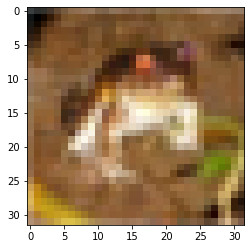

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
plt.imshow(X_train[0], cmap='binary')

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5_000)
for s in [X_train, y_train, X_val, y_val, X_test, y_test]:
    print(s.shape)

(45000, 32, 32, 3)
(45000, 1)
(5000, 32, 32, 3)
(5000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
K = tf.keras.backend

class ExponensionalLR(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.lr = []
        self.loss = []
    def on_batch_end(self, batch, logs):
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.loss.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.factor * self.model.optimizer.lr )

#### MODEL 1 - DeepDense

In [38]:
from functools import partial

DenseEluHe = partial(tf.keras.layers.Dense,
                 activation='elu',
                 kernel_initializer='he_normal')


def get_deep_dense():
    input_ = Input(shape=(32, 32, 3), name='input')
    x = Flatten()(input_)
    for _ in range(20):
        x = DenseEluHe(100)(x)

    output_ = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

    return Model(inputs=[input_], outputs=[output_], name='DeepDense')

In [43]:
class LearningRateFinder:
    def __init__(self, lr_start, lr_factor, optimizer):
        self.start = lr_start
        self.factor = lr_factor
        self.optimizer = optimizer
        
    def test_exp_lr_against_loss(self, model):
        lr_clb = ExponensionalLR(1.005)
        model.compile(
            optimizer=self.optimizer(self.start),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    callbacks=[lr_clb], verbose=0,
                    epochs=1)
        plt.plot(lr_clb.lr, lr_clb.loss)
        plt.gca().set_xscale('log')
        plt.ylim((1, 10.))

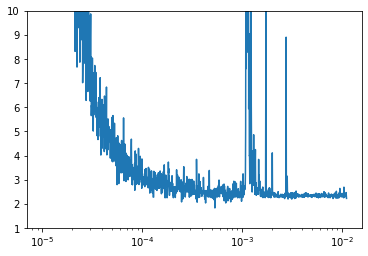

In [44]:
model = get_deep_dense()
lrf = LearningRateFinder(1e-5, 1.005, Nadam)
lrf.test_exp_lr_against_loss(model)

In [ ]:
model = get_deep_dense()

model.compile(
    optimizer=Nadam(lr=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
import os
tensorboard_path = os.path.join(os.curdir, 'my_logs/c11')
def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(tensorboard_path, run_id)

In [36]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_run_logdir())
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, 
          callbacks=[tensorboard_cb, earlystop_cb])

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 12s 257us/sample - loss: 4.3920 - accuracy: 0.2216 - val_loss: 2.4280 - val_accuracy: 0.2236
Epoch 2/50
45000/45000 [==============================] - 10s 214us/sample - loss: 1.9250 - accuracy: 0.2897 - val_loss: 1.9941 - val_accuracy: 0.2650
Epoch 3/50
45000/45000 [==============================] - 13s 295us/sample - loss: 1.8742 - accuracy: 0.3115 - val_loss: 1.9096 - val_accuracy: 0.3132
Epoch 4/50
45000/45000 [==============================] - 14s 314us/sample - loss: 1.8467 - accuracy: 0.3229 - val_loss: 2.0592 - val_accuracy: 0.2776
Epoch 5/50
45000/45000 [==============================] - 14s 311us/sample - loss: 1.8205 - accuracy: 0.3369 - val_loss: 1.9073 - val_accuracy: 0.3296
Epoch 6/50
45000/45000 [==============================] - 13s 299us/sample - loss: 1.7957 - accuracy: 0.3443 - val_loss: 1.9665 - val_accuracy: 0.3094
Epoch 7/50
45000/45000 [=====================

#### MODEL 2 - BatchNormalization

In [48]:
def get_deep_dense_normalized():
    input_ = Input(shape=(32, 32, 3), name='input')
    x = Flatten()(input_)
    for _ in range(20):
        x = Dense(100, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = elu(x)

    output_ = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

    return Model(inputs=[input_], outputs=[output_], name='DeepDenseNormalized')

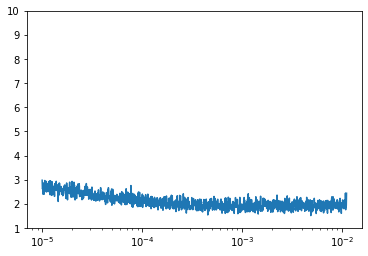

In [50]:
model = get_deep_dense_normalized()
lrf = LearningRateFinder(1e-5, 1.01, Nadam)
lrf.test_exp_lr_against_loss(model)

In [52]:
model = get_deep_dense_normalized()
model.compile(
    optimizer=Nadam(lr=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_run_logdir())
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, 
          callbacks=[tensorboard_cb, earlystop_cb])

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 22s 494us/sample - loss: 1.9574 - accuracy: 0.2774 - val_loss: 3.2014 - val_accuracy: 0.1956
Epoch 2/50
45000/45000 [==============================] - 16s 361us/sample - loss: 1.7697 - accuracy: 0.3561 - val_loss: 2.8219 - val_accuracy: 0.2178
Epoch 3/50
45000/45000 [==============================] - 17s 377us/sample - loss: 1.6717 - accuracy: 0.3955 - val_loss: 1.9076 - val_accuracy: 0.3364
Epoch 4/50
45000/45000 [==============================] - 19s 414us/sample - loss: 1.5945 - accuracy: 0.4263 - val_loss: 1.9320 - val_accuracy: 0.3682
Epoch 5/50
45000/45000 [==============================] - 17s 375us/sample - loss: 1.5365 - accuracy: 0.4482 - val_loss: 1.8404 - val_accuracy: 0.3810
Epoch 6/50
45000/45000 [==============================] - 16s 354us/sample - loss: 1.4936 - accuracy: 0.4632 - val_loss: 2.2443 - val_accuracy: 0.3362
Epoch 7/50
45000/45000 [=====================

#### MODEL 3 - SELU

In [53]:
def get_selfnormalize():
    input_ = Input(shape=(32, 32, 3), name='input')
    x = Flatten()(input_)
    for _ in range(20):
        x = Dense(100, activation='selu', kernel_initializer='lecun_normal')(x)

    output_ = Dense(10, activation='softmax', kernel_initializer='lecun_normal')(x)

    return Model(inputs=[input_], outputs=[output_], name='DeepDenseNormalized')

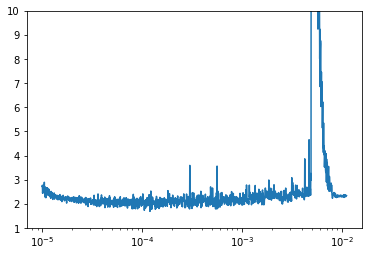

In [54]:
model = get_selfnormalize()
lrf = LearningRateFinder(1e-5, 1.01, Nadam)
lrf.test_exp_lr_against_loss(model)

In [57]:
model = get_selfnormalize()
model.compile(
    optimizer=Nadam(lr=2e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_run_logdir())
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, 
          callbacks=[tensorboard_cb, earlystop_cb])

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 13s 279us/sample - loss: 2.2024 - accuracy: 0.1612 - val_loss: 2.3842 - val_accuracy: 0.1392
Epoch 2/50
45000/45000 [==============================] - 10s 224us/sample - loss: 2.3876 - accuracy: 0.1662 - val_loss: 2.3509 - val_accuracy: 0.1362
Epoch 3/50
45000/45000 [==============================] - 10s 223us/sample - loss: 2.1681 - accuracy: 0.1600 - val_loss: 2.3246 - val_accuracy: 0.0982
Epoch 4/50
45000/45000 [==============================] - 10s 226us/sample - loss: 2.1652 - accuracy: 0.1564 - val_loss: 2.1243 - val_accuracy: 0.1822
Epoch 5/50
45000/45000 [==============================] - 10s 223us/sample - loss: 2.0915 - accuracy: 0.1798 - val_loss: 2.2719 - val_accuracy: 0.1356
Epoch 6/50
45000/45000 [==============================] - 10s 223us/sample - loss: 180.6137 - accuracy: 0.1058 - val_loss: 2.3181 - val_accuracy: 0.1048
Epoch 7/50
45000/45000 [===================

In [55]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs/c11 --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5393), started 0:17:45 ago. (Use '!kill 5393' to kill it.)